# TOLIMAN Jitter Analysis

In [1]:
import os

# jax
import dLux as dl
import dLuxToliman as dlT
import jax
from jax import device_count
from jax import random as jr
from jax import numpy as np
import jax.scipy as jsp

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import zodiax as zdx
import optax

%matplotlib inline
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

# Enable 64bit precision (note this must be run in the first cell of the notebook)
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)
print(jax.devices())

[CudaDevice(id=0)]


In [2]:
def run_grad_desc(
        model,
        data,
        params,
        optimisers: dict,
        loss_func,
        iters=100,
        plot=False,
        verbose=True,
        eps=1e-3, # termination condition
        ):
    """
    Run gradient descent on a model.
    """

    # run gradient descent
    optim, opt_state = zdx.get_optimiser(model, params, optimisers)
    losses, models_out = [], []

    if verbose:
        t = tqdm(range(iters), desc='Gradient Descent')
    else:
        t = range(iters)
        
    for i in t: 

        last_params = np.array(model.get(params))

        loss, grads = loss_func(model, data)
        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)

        models_out.append(model)
        losses.append(loss)

        if np.isnan(np.array(grads.get(params))).sum() != 0:
            raise ValueError("NaN gradient")
        if np.isneginf(np.array(grads.get(params))).sum() != 0:
            raise ValueError("Neginf gradient")
        
        if verbose:
            t.set_description("Loss: {:.6e}".format(loss)) # update the progress bar

        # Terminating condition
        new_params = np.array(model.get(params))
        if np.all(
            np.abs((last_params - new_params) / new_params) < eps
        ):
            break

    if plot:
        plt.figure()
        plt.title("Log Poisson Loss")
        plt.xlabel("Epoch")
        plt.plot(range(i+1), losses)
        plt.show()

        plt.figure()
        for param in params:
            param_out = [m.get(param) for m in models_out]
            plt.plot(range(i+1), param_out, label=param)
            plt.xlabel("Epoch")
            plt.legend()
            plt.show()


    return models_out[-1]

In [3]:
angle = 0.
mag = 0.5*0.375
shear = 0.2
r = 0.25e-4

# SETTING UP THE MODELS
oversample = 4
norm_osamp = 6
det_pscale = 0.375
det_npixels = 128 #128
kernel_size = 17
n_psfs = 4

lin_params = {"jitter_mag": mag, "jitter_angle": angle, "jitter_shape": 'linear', "n_psfs": n_psfs}
shm_params = {"jitter_mag": mag, "jitter_angle": angle, "jitter_shape": 'shm', "n_psfs": n_psfs}
norm_params = {"r": r, "shear": shear, "phi": angle, "kernel_size": kernel_size}
radial_orders = [2, 3]

# Creating common optical system
optics = dlT.TolimanOpticalSystem(
    oversample=oversample,
    psf_npixels=det_npixels,
    radial_orders=radial_orders,
    )
optics = optics.divide('aperture.basis', 1e9) # Set basis units to nanometers
norm_optics = optics.set("oversample", norm_osamp)

# Creating common source
src = dlT.AlphaCen()

# creating telescopes
lin_det = dl.LayeredDetector([('Downsample', dl.Downsample(oversample))])
shm_det = lin_det
norm_det = dl.LayeredDetector([
    ('Jitter', dlT.GaussianJitter(**norm_params)),
    ('Downsample', dl.Downsample(norm_osamp)),
])

lin_tel = dlT.JitteredToliman(source=src, optics=optics, **lin_params).set('detector', lin_det)
shm_tel = dlT.JitteredToliman(source=src, optics=optics, **shm_params).set('detector', shm_det)
norm_tel = dlT.Toliman(source=src, optics=norm_optics).set('detector', norm_det)

# creating simulated data
lin_data = lin_tel.jitter_model()
shm_data = shm_tel.jitter_model()
norm_data = norm_tel.model()

# setting norm_tel to a reasonable oversample
norm_tel = norm_tel.set(['oversample', "Downsample.kernel_size"], 2*[oversample])



2024-11-27 08:34:54.729012: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng2{k2=1,k3=0} for conv (f64[1,1,768,768]{3,2,1,0}, u8[0]{0}) custom-call(f64[1,1,768,768]{3,2,1,0}, f64[1,1,17,17]{3,2,1,0}), window={size=17x17 pad=8_8x8_8}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-27 08:34:55.631176: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.902269235s
Trying algorithm eng2{k2=1,k3=0} for conv (f64[1,1,768,768]{3,2,1,0}, u8[0]{0}) custom-call(f64[1,1,768,768]{3,2,1,0}, f64[1,1,17,17]{3,2,1,0}), window={size=17x17 pad=8_8x8_8}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode

In [4]:
jitter_model_fn = lambda model, data: jsp.stats.poisson.logpmf(model.jitter_model(), data).sum()
calc_cov = lambda model, data, parameters: zdx.covariance_matrix(model, parameters, jitter_model_fn, data, shape_dict={'wavelengths': 1})
norm_calc_cov = lambda model, data, parameters: zdx.covariance_matrix(model, parameters, zdx.poiss_loglike, data, shape_dict={'wavelengths': 1})

models = {
    'lin': lin_tel.set(
        ["separation", "jitter_mag", "jitter_angle"],
        [np.array(1.0 * lin_tel.separation), np.array(0.5 * lin_tel.jitter_mag), 5 + np.array(lin_tel.jitter_angle)],
        ),
    'shm': shm_tel.set(
        ["separation", "jitter_mag", "jitter_angle"],
        [np.array(1.0 * shm_tel.separation), np.array(0.5 * shm_tel.jitter_mag), 5 + np.array(shm_tel.jitter_angle)],
        ),
    "norm": norm_tel.set(
        [
            # "separation",
            "Jitter.r",
            "Jitter.shear",
            "Jitter.phi",
        ],
        [
            # np.array(1.05 * norm_tel.separation),
            np.array(1.05 * norm_tel.Jitter.r), 
            np.array(0.9),
            5. + np.array(norm_tel.Jitter.phi),
        ],
    ),
    }

loglike_fns = {'lin': jitter_model_fn, 'shm': jitter_model_fn, "norm": zdx.poiss_loglike}
datas = {
    'lin': lin_data,
    'shm': shm_data,
    "norm": norm_data,
    }

common_params = [
    'separation',
    'position_angle',
    'x_position',
    'y_position',
    'log_flux',
    'contrast',
    'wavelengths',
    'psf_pixel_scale',  
]

lin_params = [
    'jitter_mag',
    'jitter_angle',
    'aperture.coefficients',
]

norm_params = [
    'Jitter.r',
    'Jitter.shear',
    'Jitter.phi',
    'aperture.coefficients',
]

params = {
    "lin": common_params + lin_params,
    "shm": common_params + lin_params,
    "norm": common_params + norm_params,
}

cov_fns = {
    "lin": zdx.filter_jit(calc_cov),
    "shm": zdx.filter_jit(calc_cov),
    "norm": zdx.filter_jit(norm_calc_cov),
}


In [5]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e100}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e100, shed_dict)


base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)
base_adam = lambda vals: optax.adam(vals)

sgd = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))
adam = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))

In [6]:
# # plt.rcParams["figure.dpi"] = 300

# optimisers = {
#     "separation": sgd(5e-8, 0),
#     "Jitter.r": sgd(1e-15, 20, (150, 3)),
#     # "Jitter.shear": sgd(1e-10, 10, (150, 3)),
#     "Jitter.phi": sgd(2e-3, 10),
# }

# gd_model = run_grad_desc(
#     models['norm'],
#     datas['lin'],
#     params=list(optimisers.keys()),
#     optimisers=list(optimisers.values()),
#     iters=1000,
#     jitter_model=False,
#     plot=True,
# )


In [7]:
# seps = {}

# # Gradient descent
# optimisers = {
#     "jitter_mag": sgd(1.5e-6, 10),
#     "jitter_angle": sgd(3e-1, 10),
#     "separation": sgd(5e-8, 0),
# }

# for model_key in models.keys():
#     model = models[model_key]
#     for data_key in tqdm(datas.keys()):
#         data = datas[data_key]
#         if model_key == "norm":
#             jitter_flag = False
#         else:
#             jitter_flag = True

#         gd_model = run_grad_desc(
#             model,
#             data,
#             list(optimisers.keys()),
#             optimisers=list(optimisers.values()),
#             iters=100,
#             jitter_model=jitter_flag,
#             plot=False,
#         )

#         m()

#         cov = cov_fns[model_key](gd_model, data, params[model_key])
#         sep = np.sqrt(np.abs(cov[0, 0]))
#         seps[f"{model_key}_{data_key}"] = float(sep)

#         m()
# print(seps)

In [8]:
# maxtrix = 1e3*np.array(list(seps.values())).reshape(2, 3)
# print(maxtrix)

# plt.figure(figsize=(6, 3))
# plt.imshow(maxtrix, cmap='Wistia', origin='upper')
# plt.xticks([0, 1, 2], ['Linear', 'SHM', 'Norm'])
# plt.yticks([0, 1,], ['Linear', 'SHM',])
# for i in range(maxtrix.shape[0]):
#     for j in range(maxtrix.shape[1]):
#         plt.text(j, i, f"{maxtrix[i, j]:.5f}", ha='center', va='center', color='k')
# plt.colorbar(label='Separation Error (arcsec)')
# plt.xlabel('Data')
# plt.ylabel('Model')

# plt.show()

In [9]:

# rs = np.logspace(-8, -3, 100)
# for data_key in datas.keys():
#     Ls = []
#     min_index = 0
#     min_L = float('inf')
#     for i, r in enumerate(rs):
#         L = loss_func(norm_tel.set('Jitter.r', r), datas[data_key])
#         Ls.append(L)
#         if L < min_L:
#             min_L = L
#             min_index = i

#     Ls = np.array(Ls)

#     plt.loglog(rs, Ls, label=data_key)
#     plt.axvline(norm_tel.Jitter.r)
#     plt.scatter(rs[min_index], min_L, marker='x', color='red')

# plt.title(f'Log Poisson Loss')
# plt.xlabel('r')
# plt.legend()
# plt.show()


# Biases

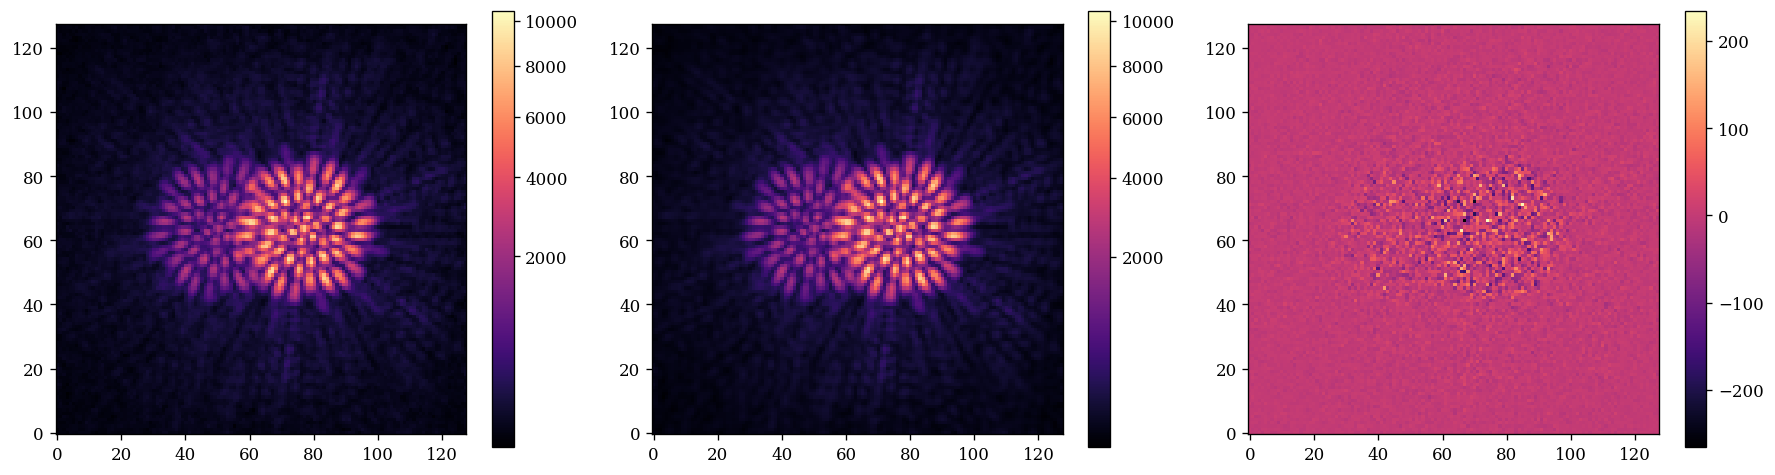

In [10]:
import matplotlib as mpl
d = datas['lin']

n = jr.poisson(jr.PRNGKey(0), d)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(n, norm=mpl.colors.PowerNorm(gamma=0.5))
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(d, norm=mpl.colors.PowerNorm(gamma=0.5))
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(d-n)
plt.colorbar()

plt.tight_layout()
plt.show()

In [11]:
# import random
# sep_dict = {}
# n_realisations = 10000

# # Gradient descent
# optimisers = {
#     "jitter_mag": sgd(1.5e-6, 10),
#     "jitter_angle": sgd(3e-1, 10),
#     "separation": sgd(5e-8, 0),
# }

# for i in tqdm(range(n_realisations), desc='Noise Realisations'):
#     for model_key in tqdm(models.keys(), desc="Models"):
#         model = models[model_key]
#         for data_key in tqdm(datas.keys(), desc='Data Arrays'):
#             data = datas[data_key]
#             if model_key == "norm":
#                 jitter_flag = False
#             else:
#                 jitter_flag = True

#             save_path = f"data/biases/{model_key}_{data_key}.npy"

#             try:
#                 sep_values = np.load(save_path)
#             except:
#                 sep_values = np.array([], dtype=np.float64)

#             noisy_data = jr.poisson(
#                 jr.PRNGKey(random.randint(0, int(1e8))), 
#                 data,
#                 )

#             gd_model = run_grad_desc(
#                 model,
#                 noisy_data,
#                 list(optimisers.keys()),
#                 optimisers=list(optimisers.values()),
#                 iters=40,
#                 jitter_model=jitter_flag,
#                 plot=False,
#             )

#             np.save(save_path, np.append(sep_values, gd_model.separation))


In [12]:
sep_dict_save_dir = "/media/morgana2/max/data/toliman/sep_dicts/"

In [ ]:
import random
from datetime import datetime

sep_dict = {}
n_realisations = 50

# Gradient descent
optimisers = {
    "jitter_mag": sgd(1.5e-6, 0),
    "jitter_angle": sgd(3e-1, 0),
    "separation": sgd(5e-8, 0),
}

@zdx.filter_jit
@zdx.filter_value_and_grad(list(optimisers.keys()))
def loss_func_jitter(model, data):
    model_array = model.jitter_model()
    return -np.nansum(jsp.stats.poisson.logpmf(data, model_array))
    
@zdx.filter_jit
@zdx.filter_value_and_grad(list(optimisers.keys()))
def loss_func_normal(model, data):
    model_array = model.model()
    return -np.nansum(jsp.stats.poisson.logpmf(data, model_array))


for model_key in tqdm(models.keys(), desc="Models"):
    model = models[model_key]

    if model_key == "norm":
        continue
        jitter_flag = False
        loss_func = loss_func_normal
    else:
        jitter_flag = True
        loss_func = loss_func_jitter

    for data_key in tqdm(datas.keys(), desc='Data Arrays'):
        data = datas[data_key]
        sep_values = np.array([], dtype=np.float64)
        
        for i in tqdm(range(n_realisations), desc='Noise Realisations'):

            noisy_data = jr.poisson(
                jr.PRNGKey(random.randint(0, int(1e8))), 
                data,
                )

            gd_model = run_grad_desc(
                model,
                noisy_data,
                list(optimisers.keys()),
                optimisers=list(optimisers.values()),
                iters=40,
                loss_func=loss_func,
                plot=False,
                verbose=False,
            )

            sep_values = np.append(sep_values, gd_model.separation)

        sep_dict[f"{model_key}_{data_key}"] = sep_values

current_time = datetime.now().strftime('%d-%m-%Y_%H-%M')
save_str = current_time + f"_{n_realisations:04d}.npy"

np.save(os.path.join(sep_dict_save_dir, save_str), sep_dict)

Models:   0%|          | 0/3 [00:00<?, ?it/s]

Data Arrays:   0%|          | 0/3 [00:00<?, ?it/s]

Noise Realisations:   0%|          | 0/50 [00:00<?, ?it/s]

Noise Realisations:   0%|          | 0/50 [00:00<?, ?it/s]

Noise Realisations:   0%|          | 0/50 [00:00<?, ?it/s]

Data Arrays:   0%|          | 0/3 [00:00<?, ?it/s]

Noise Realisations:   0%|          | 0/50 [00:00<?, ?it/s]

Noise Realisations:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# noisy_data = np.clip(jr.poisson(
#     jr.PRNGKey(random.randint(0, int(1e8))), 
#     data,
#     ), min=1)

# gd_model = run_grad_desc(
#     model,
#     noisy_data,
#     list(optimisers.keys()),
#     optimisers=list(optimisers.values()),
#     iters=40,
#     loss_func=loss_func,
#     plot=True,
#     verbose=True,
# )

In [ ]:
# import random
# sep_dict = {}
# n_realisations = 3000

# for model_key in tqdm(models.keys(), desc="Models"):
#     model = models[model_key]
#     for data_key in tqdm(datas.keys(), desc='Data Arrays'):
#         data = datas[data_key]
#         if model_key == "norm":
#             jitter_flag = False
#         else:
#             jitter_flag = True

#         sep_values = []

#         for i in tqdm(range(n_realisations), desc='Noise Realisations'):
#             noisy_data = jr.poisson(
#                 jr.PRNGKey(random.randint(0, int(1e8))), 
#                 data,
#                 )

#             gd_model = run_grad_desc(
#                 model,
#                 noisy_data,
#                 list(optimisers.keys()),
#                 optimisers=list(optimisers.values()),
#                 iters=40,
#                 jitter_model=jitter_flag,
#                 plot=False,
#             )

#             sep_values.append(gd_model.separation)

#         sep_dict[f"{model_key}_{data_key}"] = np.array(sep_values)

# zdx.experimental.serialise('data/sep_dict.zdx', sep_dict)


In [ ]:
# zdx.experimental.serialise('data/sep_dict.zdx', sep_dict)


In [21]:
total_sep_dict = {}

# looping over saved sep_dicts
for f in os.listdir(sep_dict_save_dir):
    if not f.endswith(".npy"):
        continue

    # loading each file
    this_dict = np.load(os.path.join(sep_dict_save_dir, f), allow_pickle=True).item()
    
    # appending to total_sep_dict
    for k in this_dict.keys():
        total_sep_dict[k] = np.append(total_sep_dict[k], this_dict[k]) if k in total_sep_dict.keys() else this_dict[k]


700


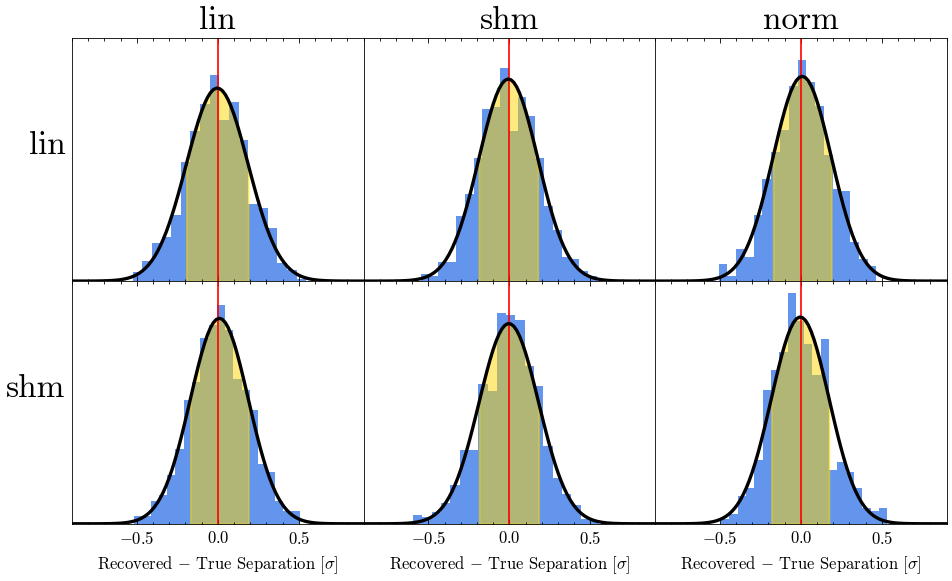

In [26]:
%matplotlib inline

import scienceplots
plt.style.use(['science', 'bright', 'no-latex'])

print(len(list(total_sep_dict.values())[0]))

n_bins = 20
true_sep = 10.0
fontsize = 20
fisher_sigma = 2.56e-3

fig, ax = plt.subplots(2, 3, figsize=(8, 5), sharex=True, sharey=True)
fig.subplots_adjust(
    top=0.915,
    bottom=0.106,
    left=0.074,
    right=0.985,
    hspace=0.0,
    wspace=0.0,
    )

for i in range(2):
    for j in range(3):

        # mu, sigma = jax.scipy.stats.norm.fit(results[key])
        key = f"{list(models.keys())[i]}_{list(datas.keys())[j]}"
        # results = np.load(f"data/biases/{key}.npy")
        results = total_sep_dict[key]
        offset_hist = (results - true_sep) / fisher_sigma  # in sigma units


        ax[i][j].hist(
            offset_hist,
            bins=n_bins,
            density=True,
            color="cornflowerblue",
            alpha=1.,
            )
        ax[i][j].set(
            title=f"{key}",
            xlabel=r'Recovered $-$ True Separation [$\sigma$]',
            xlim=(-0.9, 0.9),
            yticks=[],
            )
        
        ax[i][j].axvline(0, color='red', linestyle='-')

        # Generate the best-fit normal distribution curve
        mu = np.mean(offset_hist)
        std = np.std(offset_hist)

        xmin, xmax = plt.xlim()
        
        xs = np.linspace(xmin, xmax, 100)
        bell_curve = jax.scipy.stats.norm.pdf(xs, mu, std)

        one_sigma_xs = np.linspace(mu - std, mu + std, 100)
        one_sigma_bell = jax.scipy.stats.norm.pdf(one_sigma_xs, mu, std)

        # Plot the normal distribution curve
        ax[i][j].plot(xs, bell_curve, 'k', linewidth=2)
        ax[i][j].fill_between(one_sigma_xs, one_sigma_bell, color='gold', alpha=0.5, zorder=1)

        if j == 0:
            ax[i][j].set_ylabel(f"{list(models.keys())[i]}", fontsize=fontsize, rotation=0, ha='right')
        else:
            ax[i][j].set(
                ylabel=None,
            )
        if i == 0:
            ax[i][j].set(
                xlabel=None,
            )
            ax[i][j].set_title(f"{list(datas.keys())[j]}", fontsize=fontsize)  # Set the text size of the title
        else:
            ax[i][j].set(
                title=None,
            )

# plt.tight_layout()
# plt.savefig('figs/biases.png', dpi=500)
plt.show()


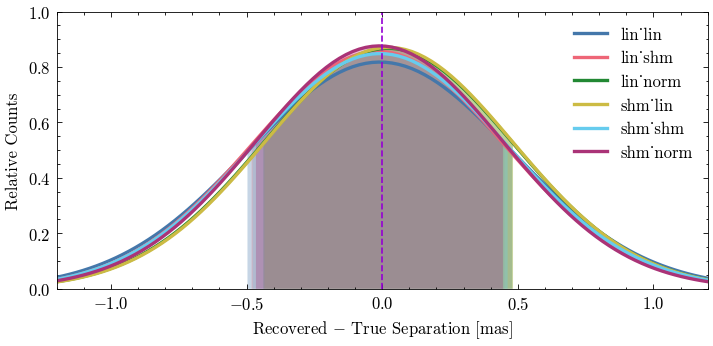

In [23]:
fig, ax = plt.subplots(figsize=(7, 3))

ax.set(
    # title='All Biases',
    xlabel=r'Recovered $-$ True Separation [mas]',
    ylabel="Relative Counts",
    # yticks=[],
    ylim=(0, None),
    xlim=(-1.2, 1.2),
    )

for key, seps in total_sep_dict.items():

    offset_hist = 1e3 * (seps - true_sep)  # in milliarcseconds

    # ax.hist(
    #     offset_hist,
    #     bins=n_bins,
    #     density=True,
    #     alpha=0.5,
    #     # label=key,
    #     )
    
    # Generate the best-fit normal distribution curve
    mu = np.mean(offset_hist)
    std = np.std(offset_hist)

    xmin, xmax = plt.xlim()
    
    xs = np.linspace(xmin, xmax, 100)
    bell_curve = jax.scipy.stats.norm.pdf(xs, mu, std)

    one_sigma_xs = np.linspace(mu - std, mu + std, 100)
    one_sigma_bell = jax.scipy.stats.norm.pdf(one_sigma_xs, mu, std)

    # Plot the normal distribution curve
    ax.plot(xs, bell_curve, linewidth=2, label=key)
    ax.fill_between(one_sigma_xs, one_sigma_bell, alpha=0.3, zorder=1)
    
ax.axvline(0, color='darkviolet', linestyle='--')
plt.legend()
plt.show()